# ROMS Ocean Model Example

The Regional Ocean Modeling System ([ROMS](http://myroms.org)) is an open source hydrodynamic model that is used for simulating currents and water properties in coastal and estuarine regions. ROMS is one of a few standard ocean models, and it has an active user community.

ROMS uses a regular C-Grid in the horizontal, similar to other structured grid ocean and atmospheric models, and a stretched vertical coordinate (see [the ROMS documentation](https://www.myroms.org/wiki/Vertical_S-coordinate) for more details). Both of these require special treatment when using `xarray` to analyze ROMS ocean model output. This example notebook shows how to create a lazily evaluated vertical coordinate, and make some basic plots. The `xgcm` package is required to do analysis that is aware of the horizontal C-Grid.

In [1]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

import xarray as xr

Load a sample ROMS file. This is a subset of a full model available at 

    http://barataria.tamu.edu/thredds/catalog.html?dataset=txla_hindcast_agg
    
The subsetting was done using the following command on one of the output files:

    #open dataset
    ds = xr.open_dataset('/d2/shared/TXLA_ROMS/output_20yr_obc/2001/ocean_his_0015.nc')
    
    # Turn on chunking to activate dask and parallelize read/write.
    ds = ds.chunk({'ocean_time': 1})
    
    # Pick out some of the variables that will be included as coordinates
    ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
    
    # Select a a subset of variables. Salt will be visualized, zeta is used to 
    # calculate the vertical coordinate
    variables = ['salt', 'zeta']
    ds[variables].isel(ocean_time=slice(47, None, 7*24), 
                       xi_rho=slice(300, None)).to_netcdf('ROMS_example.nc', mode='w')

So, the `ROMS_example.nc` file contains a subset of the grid, one 3D variable, and two time steps.

### Load in ROMS dataset as an xarray object

In [2]:
# load in the file
ds = xr.tutorial.open_dataset('ROMS_example.nc', chunks={'ocean_time': 1})

# This is a way to turn on chunking and lazy evaluation. Opening with mfdataset, or 
# setting the chunking in the open_dataset would also achive this.
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 2, s_rho: 30, eta_rho: 191, xi_rho: 371)
Coordinates:
    Cs_r        (s_rho) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 371), meta=np.ndarray>
    hc          float64 ...
    h           (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 371), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 371), meta=np.ndarray>
    Vtransform  int32 ...
  * ocean_time  (ocean_time) datetime64[ns] 2001-08-01 2001-08-08
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 191, 371), meta=np.ndarray>
    zeta        (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 191, 371), meta=np.ndarray>
Attributes: (12/34)
    file:              ../output_20yr_obc/2001/ocean_his_0015.nc
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             TXLA ROMS hindcast run with dyes and oxygen
    rst_file:          ../output_20yr_obc/2001/ocean_rst.nc
    ...                ...
    compiler_flags:    -heap-arrays -fp-model fast -mt_mpi -ip -O3 -msse2 -free
    tiling:            010x012
    history:           Tue Jul 24 11:04:43 2018: /opt/nco/ncks -D 4 -t 8 /cop...
    ana_file:          /home/d.kobashi/TXLA_ROMS_reana/Functionals/ana_btflux...
    CPP_options:       TXLA2, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_NUDGCOE...
    NCO:               netCDF Operators version 4.7.6-alpha04 (Homepage = htt...

### Add a lazilly calculated vertical coordinates

Write equations to calculate the vertical coordinate. These will be only evaluated when data is requested. Information about the ROMS vertical coordinate can be found (here)[https://www.myroms.org/wiki/Vertical_S-coordinate]

In short, for `Vtransform==2` as used in this example, 

$Z_0 = (h_c \, S + h \,C) / (h_c + h)$

$z = Z_0 (\zeta + h) + \zeta$

where the variables are defined as in the link above.

In [3]:
if ds.Vtransform == 1:
    Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
    z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
elif ds.Vtransform == 2:
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho

ds.coords['z_rho'] = z_rho.transpose()   # needing transpose seems to be an xarray bug
ds.salt

<xarray.DataArray 'salt' (ocean_time: 2, s_rho: 30, eta_rho: 191, xi_rho: 371)>
dask.array<open_dataset-f4e7273483078c283f79554cc1c255b9salt, shape=(2, 30, 191, 371), dtype=float32, chunksize=(1, 30, 191, 371), chunktype=numpy.ndarray>
Coordinates:
    Cs_r        (s_rho) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    lon_rho     (xi_rho, eta_rho) float64 dask.array<chunksize=(371, 191), meta=np.ndarray>
    hc          float64 20.0
    h           (xi_rho, eta_rho) float64 dask.array<chunksize=(371, 191), meta=np.ndarray>
    lat_rho     (xi_rho, eta_rho) float64 dask.array<chunksize=(371, 191), meta=np.ndarray>
    Vtransform  int32 2
  * ocean_time  (ocean_time) datetime64[ns] 2001-08-01 2001-08-08
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    z_rho       (s_rho, xi_rho, eta_rho, ocean_time) float64 dask.array<chunksize=(30, 371, 191, 1), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  salinity
    time:       ocean_time
    field:      salinity, scalar, series

### A naive vertical slice

Creating a slice using the s-coordinate as the vertical dimension is typically not very informative.

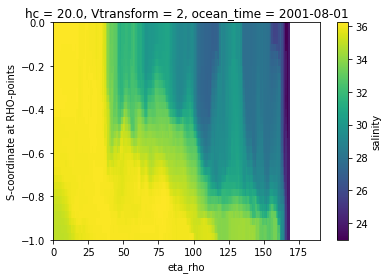

In [4]:
ds.salt.isel(xi_rho=50, ocean_time=0).plot()

We can feed coordinate information to the plot method to give a more informative cross-section that uses the depths. Note that we did not need to slice the depth or longitude information separately, this was done automatically as the variable was sliced.

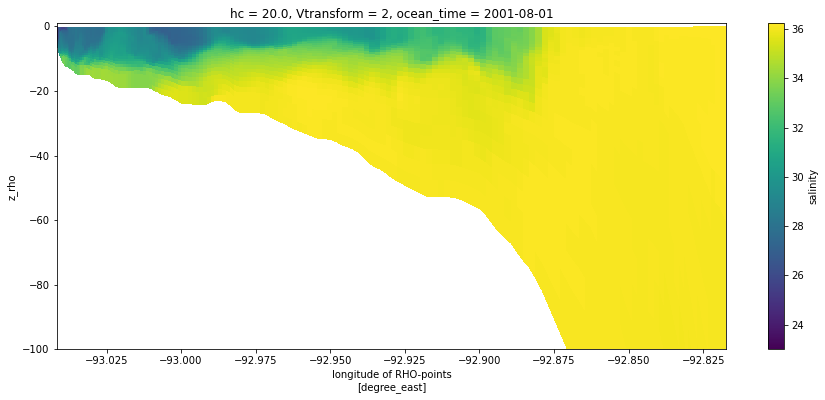

In [5]:
section = ds.salt.isel(xi_rho=50, eta_rho=slice(0, 167), ocean_time=0)
section.plot(x='lon_rho', y='z_rho', figsize=(15, 6), clim=(25, 35))
plt.ylim([-100, 1]);

### A plan view

Now make a naive plan view, without any projection information, just using lon/lat as x/y. This looks OK, but will appear compressed because lon and lat do not have an aspect constrained by the projection.

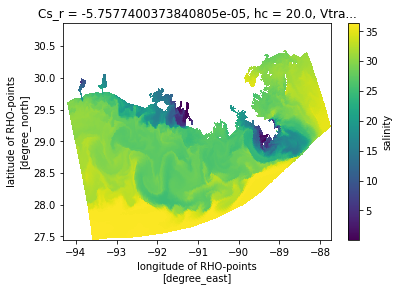

In [6]:
ds.salt.isel(s_rho=-1, ocean_time=0).plot(x='lon_rho', y='lat_rho')

And let's use a projection to make it nicer, and add a coast.

/usr/share/miniconda3/envs/dash-docs/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


/usr/share/miniconda3/envs/dash-docs/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


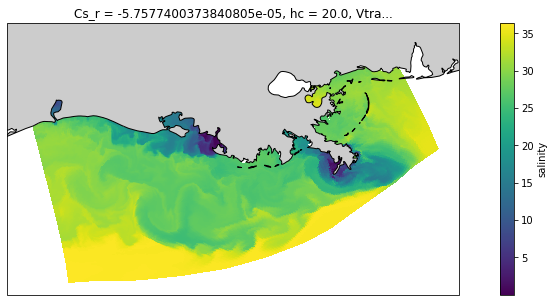

In [7]:
proj = ccrs.LambertConformal(central_longitude=-92, central_latitude=29)
fig = plt.figure(figsize=(15, 5))
ax = plt.axes(projection=proj)
ds.salt.isel(s_rho=-1, ocean_time=0).plot(x='lon_rho', y='lat_rho', 
                                          transform=ccrs.PlateCarree())

coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k', facecolor='0.8')
ax.add_feature(coast_10m)